# common lib

In [3]:
import datetime
import logging
from typing import Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from dateutil import parser
#from omicron.models.timeframe import TimeFrame as tf

logger = logging.getLogger(__name__)

APPROX_BDAYS_PER_YEAR = 252

cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 fee".split(" ")

home = "/data/traders/"

def int2date(x):
    if isinstance(x, float):
        x = int(x)

    return parser.parse(str(x)).date()


class NoOpenTradesError(Exception):
    pass


from collections import defaultdict

from dateutil import parser

def peek(name):
    _dir = os.path.join(home, name)
    
    for file in os.listdir(_dir):
        path = os.path.join(_dir, file)
    
        for encoding in ["gbk", "utf-8"]:
            try:
                df = pd.read_csv(path, encoding=encoding)
                print(df[:5])
                print( file, "csv", encoding, list(set(cols) - set(df.columns)))
            except Exception:
                pass
                
        try:
            df = pd.read_excel(path)
            print(df[:5])
            print(path, "excel", list(set(cols) - set(df.columns)))
        except Exception as e:
            pass
        
        
class Trade:
    LONG = 1
    INTEREST = 2
    SHORT = -1
    DEDUCT = -2
    OTHER = 0

    OPENED = 0
    CLOSED = 1

    def __init__(self, row, i):
        self.seq = i
        self.shares = abs(row["成交数量"])

        self.name = row["证券名称"]
        self.code = row["证券代码"]

        self.price = row["成交均价"]
        self.money = row["成交金额"]
        self.fee = row["fee"]
        self.date = row["成交日期"]

        self.status = self.OPENED
        self.op = row["操作"]

        if self.op.find("卖出") != -1:
            self.flag = self.SHORT
        elif self.op.find("买入") != -1:
            self.flag = self.LONG
        elif self.op in ("红股派息", "债券兑息"):
            self.flag = self.INTEREST
            self.status = self.CLOSED
        elif self.op.find("扣款") != -1:
            self.flag = self.DEDUCT
            self.status = self.CLOSED
        else:
            self.flag = self.OTHER

        # only for LONG trades
        if self.flag == self.LONG:
            self.unsell = self.shares

            self._profit = 0
            self.holding_days = 0

    def sell(self, shares, price, fee, close_dt):
        """从当前未售出股中售出。

        计算时将根据售出的股数，分摊买入和卖的交易成本。返回未售出的股份和未分摊的成本。
        """
        assert self.flag == self.LONG

        if self.status != self.CLOSED:
            assert (
                self.unsell > 0
            ), f"{self.name}, {self.unsell}, {self.status}, {self.shares}"

            sellable = min(shares, self.unsell)

            # 计算本次交易的收益，并分摊交易成本
            amortized_buy_fee = self.fee * sellable / self.shares
            amortized_sell_fee = fee * sellable / shares

            self._profit += (
                sellable * (price - self.price) - amortized_buy_fee - amortized_sell_fee
            )

            # 持仓日期, 可转债交易和做T会出现持仓日期为0的情况。持仓日期为零为使得年化收益成为
            # 正负无穷。为简单起见，设置最低持仓天数为1
            holding_days = max(1, (close_dt - self.date).days)
            #holding_days = max(1, tf.count_day_frames(self.date, close_dt))
            self.holding_days += holding_days * sellable / self.shares

            # 调整可卖股数
            self.unsell -= sellable
            if self.unsell == 0:
                self.status = self.CLOSED

            return shares - sellable, fee - amortized_sell_fee

    @property
    def profit(self):
        assert self.flag == self.LONG
        return self._profit

    @property
    def percentage_profit(self):
        assert self.flag == self.LONG
        return self._profit / (self.shares * self.price)

    @property
    def closed(self):
        return self.status == self.CLOSED

    @closed.setter
    def closed(self, value):
        self.status = self.CLOSED if value else self.OPENED

    def __str__(self):
        return f"{self.name}[{self.code}]: {self.op}\n成交股数：{self.shares}\n成交均价：{self.price}\n成交金额：{self.money}\n成交日期：{self.date}\n"

    def __repr__(self) -> str:
        return self.__str__()


class Evaluator:
    def __init__(self,name: str, file: str, preprocessor: Callable) -> None:
        self.name = name
        self.file = os.path.join(home, name, file)
        self.preprocessor = preprocessor
        self.range = None
        self.df = None
        self.returns = None

        self.unpaired_long = []
        self.unpaired_short = []

    def read_bill(self):
        df = self.preprocessor(self.file)
        
        missed_fields = set(cols) - set(df.columns)
        if len(missed_fields):
            raise AssertionError(f"缺少这些字段:{missed_fields}")
        
        try:
            df["证券代码"] = [
                f"{int(code):06}" if not np.isnan(code) else "" for code in df["证券代码"]
            ]
        except:
            pass

        self.df = df.sort_values("成交日期", ascending=True)
        self.df.reset_index(inplace=True)
        self.range = (self.df.iloc[0]["成交日期"].date(), self.df.iloc[-1]["成交日期"].date())
        
        long = defaultdict(list)
        short = defaultdict(list)

        skipped = []
        for index, row in self.df.iterrows():
            trade = Trade(row, index)

            if trade.flag == Trade.LONG:
                long[trade.code].append(trade)
            elif trade.flag == Trade.SHORT:
                short[trade.code].append(trade)
            else:
                skipped.append(index)
        return long, short, self.df, skipped

    def close_transactions(self, long_trades, short_trades):
        for code, _long_trades in long_trades.items():
            i = 0
            if short_trades.get(code) is None:
                continue

            try:
                for short in short_trades.get(code):
                    sellable, price, fee, close_dt = (
                        short.shares,
                        short.price,
                        short.fee,
                        short.date,
                    )

                    while sellable > 0:
                        while _long_trades[i].closed:
                            i += 1
                            if i >= len(_long_trades):
                                raise NoOpenTradesError

                        long = _long_trades[i]
                        sellable, fee = long.sell(sellable, price, fee, close_dt)
                    
                    short.closed = True
            except NoOpenTradesError:
                pass

        returns = []
        for code, trades in long_trades.items():
            for t in trades:
                if t.profit != 0:
                    returns.append((t.date, t.name, t.profit, t.percentage_profit, t.holding_days))
                if not t.closed:
                    self.unpaired_long.append(t)

        for code, trades in short_trades.items():
            for t in trades:
                if not t.closed:
                    self.unpaired_short.append(t)

        returns = pd.DataFrame(
            returns, columns=["date", "name", "profit", "pprofit", "days"]
        )
        returns["daily_pprofit"] = returns["pprofit"] / returns["days"]

        self.returns = returns.sort_values("date")
        
    def report(self):
        total_profit = sum(self.returns.profit.values)
        average_holding_days = np.mean(self.returns.days)

        print(f"\n====== {self.name} 交易评估报告 ======")
        print("交易次数", len(self.returns))
        print("操作区间", self.range[0], '-', self.range[-1])
        print("总利润:", round(total_profit, 2))
        print("持仓天数:", round(average_holding_days, 2))
        print("\n亏损最多:\n", self.returns.nsmallest(3, "pprofit"))
        print("盈利最多:\n", self.returns.nlargest(3, "pprofit"))
        print(f"笔均利润: {self.returns.pprofit.mean():.1%}")
        print(f"利润中位数: {self.returns.pprofit.median():.1%}")

        wr = len(self.returns[self.returns.profit > 0]) / len(self.returns)
        print(f"交易胜率: {wr:.2%}")

        print(" ------ ")
        print("未配对交易:")
        data = []
        for t in self.unpaired_long:
            data.append(("买入", t.date, t.name, t.code, t.shares, t.price, t.fee))

        for t in self.unpaired_short:
            data.append(("卖出", t.date, t.name, t.code, t.shares, t.price, t.fee))

        print(pd.DataFrame(data, columns=["操作", "日期", "名称", "代码", "股数", "价格", "手续费"]))

        plt.figure(figsize=(12, 6), dpi=80)
        plt.plot(self.returns["date"], np.cumsum(self.returns.profit.values))
        plt.title("资产收益曲线")

    def check(self):
        long_trades, short_trades, df, skipped = self.read_bill()

        print("操作区间：", df.iloc[0]["成交日期"].date(), "~", df.iloc[-1]["成交日期"].date())

        skipped_df = df.iloc[skipped]

        print("未处理交易笔数：", len(skipped_df))
        print("未处理交易类型：", " ".join(skipped_df["操作"].unique()))
        
        llong = sum([len(trades) for trades in long_trades.values()])
        lshort = sum([len(trades) for trades in short_trades.values()])
        
        print("\n买入笔数:", llong)
        print("卖出笔数:", lshort)

        print("\n交易记录摘要:")
        print(df[:10])

    def run(self):
        long, short, _, _ = self.read_bill()

        self.close_transactions(long, short)
        self.report()

    def preprocessor(self, file: str) -> pd.DataFrame:
        pass


def get_file(name, filename):
    return os.path.join(home, name, filename)

# 黄芬

In [ ]:
def preprocess_hf(f)->pd.DataFrame:
    return pd.read_excel(f, parse_dates=["成交日期"])

name = "黄芬"
file = os.path.join(home, name, "交易数据黄芬.xlsx")
e = Evaluator(name, file, preprocess_hf)
e.run()

# 张恒

In [ ]:
df = pd.read_csv("/tmp/zh.xls", encoding="gbk", sep="\t")

In [ ]:
def preprocess_zh(f)->pd.DataFrame:
    df = pd.read_csv(f, sep="\t", encoding="gbk")
    data = []
    
    for _, r in df.iterrows():
        buy_fields = "买入日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 手续费"
        values = [r[k] for k in buy_fields.split(" ")]
        # 印花税 手续费
        values.extend([0, 0])
        
        data.append(values)
        sell_fields = "卖出日期 证券代码.1 证券名称.1 操作.1 成交均价.1 成交数量.1 成交金额.1 手续费.1 印花税 过户费"
        values = [r[k] for k in sell_fields.split(" ")]
        if np.isnan(values[0]):
            continue
        data.append(values)
        
    cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 手续费 印花税 过户费"
    df = pd.DataFrame(data, columns=cols.split(" "))
    df["成交日期"] = [int2date(x) for x in df["成交日期"].values]
    
    return df

file = os.path.join(home, "张恒", "zh.xls")
e = Evaluator("张恒", file, preprocess_zh)
e.run()

# 向光华

In [ ]:
def preprocess_xgh(file):
    print("file: ", file)
    df = pd.read_csv(file, encoding='gbk', sep="\t", parse_dates=["成交日期"])

    return df

name = "向光华"
file = get_file(name)
e = Evaluator(name, file, preprocess_xgh)
e.run()

# 程武

In [ ]:
def preprocess_cw(file):
    with open(file) as f:
        lines = f.readlines()
    
    data = []
    for line in lines:
        line = line.strip()
        if len(line) == 0:
            continue
        line = line.replace("   = ", " ").replace("   ", " ")
        data.append(",".join(line.split(" ")))
        
    import io
    stream = io.StringIO("\n".join(data))
    df = pd.read_csv(stream, parse_dates=["成交日期"])
    
    df.rename({
        "委托方向": "操作",
        "交易规费": "其它杂费"
    }, inplace=True, axis="columns")
    
    return df

In [ ]:
name = "程武"
file = get_file(name)
e = Evaluator(name, file, preprocess_cw)
e.run()

# 高述彪

In [ ]:
def preprocess_gxb(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["建仓日期"])
    df.rename({
        "持股天数":"days", 
        "盈亏比例(%)":"pprofit",
        "建仓日期":"date",
        "总盈亏":"profit",
    },axis="columns", inplace=True)
    
    df["daily_pprofit"] = df["pprofit"]/df["days"]/100
    return df

In [ ]:
file = f"/tmp/table-1.xls"
returns = preprocess_gxb(file)
df = report(returns[["date", "days", "profit", "pprofit", "daily_pprofit"]])

# 王聪

In [ ]:
等待交割单。截屏已有

# 毛西凉

In [ ]:
pd.read_excel("/tmp/mxl.xlsx")[:5]

In [ ]:
def preprocessor_mxl(file):
    df = pd.read_excel(file)
    df["成交日期"] = df["成交日期"].apply(lambda x: parser.parse(str(x)))
    return df

df = evaluate("/tmp/mxl.xlsx", preprocessor_mxl)

# 刘彬

In [ ]:
cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 手续费 印花税 过户费 其它杂费"
def preprocess_lb(file):
    from io import StringIO
    with open(file, encoding="gbk") as f:
        data = []
        for line in f.readlines():
            fields = line.strip().replace("=","").replace('"', "").split("\t")
            data.append("\t".join(fields))
            
    data = "\n".join(data)
    df = pd.read_csv(StringIO(data), sep="\t", parse_dates=["发生日期"])
    df = df[(df['业务名称'] == "证券买入") | (df['业务名称'] == "证券卖出")]
    
    df.rename({"发生日期":"成交日期", "买卖标志": "操作", "成交价格": "成交均价"}, axis="columns", inplace=True)
    fee = []
    for i in range(len(df)):
        if df.iloc[i]["业务名称"] == "证券买入":
            fee.append((df.iloc[i]["清算金额"] + df.iloc[i]["成交金额"]) *-1)
        else:
            fee.append(df.iloc[i]["清算金额"] - df.iloc[i]["成交金额"])
            
    df["手续费"] = np.abs(fee)
    df["成交数量"] = np.abs(df["成交数量"])
    return df

evaluate("/tmp/lb.xls", preprocess_lb)


In [ ]:
preprocess_lb("/tmp/lb.xls")

In [ ]:
df = preprocess_lb("/tmp/lb.xls")
df

# 陶陶

In [ ]:
def preprocess_500(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["发生日期"])
    df.rename({"发生日期":"成交日期", "交易类别":"操作"}, inplace=True, axis="columns")
    df["证券代码"] = df["证券代码"].str.replace("= ", "")
    return df

e = Evaluator("陶陶", "/tmp/5002.xls", preprocess_500)

In [ ]:
e.run()

# 赵波

In [ ]:
def preprocess_zb(file) -> pd.DataFrame:
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    df.rename({"成交价格": "成交均价", "委托类别": "操作"}, axis="columns", inplace=True)
    return df

def preprocess_zb02(file) -> pd.DataFrame:
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["交割日期"])
    df.rename(
        {"成交价格": "成交均价", "业务类型": "操作", "交割日期": "成交日期"}, axis="columns", inplace=True
    )

# e = Evaluator("赵波", "/tmp/zb.txt", preprocess_zb)
# e.run()

# e = Evaluator("赵波", "/tmp/zb2.txt", preprocess_zb2)
# e.run()

# e = Evaluator("赵波", "/tmp/zb3.txt", preprocess_zb2)
# e.run()

preprocess_zb(home + "/赵波/交割单查询.txt")

# 赵成勇

In [ ]:
def preprocess_zcy(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    
    df["fee"] = df["佣金"] + df["过户费"] + df["经手费"] + df["证管费"] + df["印花税"] + df["其他杂费"]
    return df

file = get_file("赵成勇", "zcy.xls")
e = Evaluator("赵成勇", file, preprocess_zcy)
#e.check()
e.run()

In [ ]:
df = preprocess_zcy(file)

In [ ]:
df.rename({
    "成交日期":"date",
    "证券代码":"code",
    "证券名称":"name",
    "操作":"side",
    "成交数量":"volume",
    "成交均价":"price",
    "成交金额":"amount",
}, axis='columns', inplace=True)

In [ ]:
cols = ["date", "code", "name", "side", "volume", "amount", "fee"]
df2 = df[(df["side"] == "证券买入") | (df["side"] == "证券卖出")][cols]

In [ ]:
df2["side"] = df2.side.map(lambda x: 1 if x == "证券买入" else -1)

In [ ]:
df2[2:8]

# 柴寅

In [ ]:
file = "/Users/aaronyang/Documents/business/格物致知/团队/简历/柴寅/20.9.1-20.11.1.xls"

files = ["20.9.1-20.11.1.xls", "20.11.1-21.2.1.xls",
 "21.2.1-21.5.1.xls", "21.5.1-21.8.1.xls", "21.8.1-21.11.1.xls","21.11.1-22.2.1.xls"]

#files = ["21.2.1-21.5.1.xls"]

def preprocess_cy(files):
    if isinstance(files, str):
        files = [files]
    dfs = []
    for file in files:
        f = os.path.join(home, "柴寅", file)
        df = pd.read_csv(f, encoding="gbk", sep="\t", parse_dates=["发生日期"])

        df["fee"] = df["佣金"] + df["印花税"]
        df["证券代码"] = df["证券代码"].str.replace(" =", "")
        df.rename({"交易类别":"操作", "发生日期": "成交日期"}, inplace=True, axis="columns")
        
        dfs.append(df)
        
    return pd.concat(dfs)

e = Evaluator("柴寅", files, preprocess_cy)
e.run()

In [ ]:
股票      买入价       卖出价        盈亏比

益民集团   5.03/4.79   4.46(现价)   -9%
江丰电子   63.61       63.96       0.6%
建工修复   34.06       35.98       5%
迪威迅     7.77        6.98        -10%
真视通     13.8/14.25  14.14       0.8%
中国海诚   11.5        10.06       -12%
诚邦股份   10.64       9.53        -10%
浙农股份   16.22/16.15 18.68       15%
奥维通信   6.96        7.26        4%
恒宝股份   16.21       17.12       5.6%

# 朱明鑫 - 淘汰

In [ ]:
name = "朱明鑫"
file = get_file(name, "zmx.xlsx")

In [ ]:
file

In [ ]:
def preprocess_zmx(file):
    from omicron.models.timeframe import TimeFrame
    import arrow
    df = pd.read_excel(file)

    valid = []
    dates = []
    for index , row in df.iterrows():
        dt = row["成交日期"]
        if isinstance(dt, int):
            valid.append(index)
            dates.append(arrow.get(TimeFrame.int2date(dt)).datetime)
                
    df = df.iloc[valid]
    df["成交日期"] = dates
    df["fee"] = 0
    return df

In [ ]:
e = Evaluator(name, file, preprocess_zmx)
e.run()

In [ ]:
df = preprocess_zmx(file)
df

# 李亮亮 - 淘汰

In [ ]:
name = "李亮亮"
file = get_file(name, "lll.xls")
file

In [ ]:
def preprocess_lll(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    
    df.rename({"买卖标志": "操作", "成交价格":"成交均价"}, axis="columns", inplace=True)
    df["fee"]=0
    return df

In [ ]:
e = Evaluator(name, file, preprocess_lll)
e.run()

In [ ]:
preprocess_lll(file)

In [ ]:
import jqdatasdk as jq

In [ ]:
import os
account = os.getenv("JQ_ACCOUNT")
password = os.getenv("JQ_PASSWORD")

jq.auth(account, password)

In [ ]:
fields = ['high_limit', 'low_limit']
bars = jq.get_price("002537.XSHE", end_date='2022-3-10', count=2, fields=fields)

In [ ]:
bars.to_records()

In [ ]:
fields = ['date','close','volume']
bars = jq.get_bars("603717.XSHG", 960, '1m', end_dt='2022-3-10 15:00:00', fields=fields, df=False, include_now=True)
bars

# 瞿洲

In [ ]:
cols = "成交日期 证券代码 证券名称 操作 成交均价 成交数量 成交金额 fee".split(" ")

def preprocess_qz0(file):
    df = pd.read_excel(file, sheet_name=0, parse_dates=["交易日期"])
    df.rename({"交易日期":"成交日期", "买卖标志":"操作", "成交价格":"成交均价"}, axis="columns", inplace=True)
    df["fee"] = df["佣金"] + df["印花税"] + df["过户费"]+df["其他费"]
    return df

#print(preprocess_qz("jyy/jgd.xlsx"))
e = Evaluator("瞿洲", "jyy/jgd.xlsx", preprocess_qz)
e.run()

In [ ]:
def preprocess_qz1(file):
    df = pd.read_excel(file, sheet_name=1, parse_dates=["发生日期"])
    df.rename({"发生日期":"成交日期", "交易类别":"操作"}, axis="columns", inplace=True)
    df["fee"] = 0
    return df

#print(preprocess_qz1("jyy/jgd.xlsx"))
e = Evaluator("瞿洲", "jyy/jgd.xlsx", preprocess_qz1)
e.run()

# 郑方军

In [ ]:
def pre_process_zfj(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    df["fee"] = 0
    return df

name = "郑方军"
file = "table1.xls"

e = Evaluator(name, file, pre_process_zfj)
e.run()

# 张洁

In [ ]:
def pre_process_zj(file):
    df = pd.read_csv(file, encoding="gbk", sep="\t", parse_dates=["成交日期"])
    df["fee"] = df["手续费"] + df["印花税"] + df["其他杂费"]
    return df

name = "张洁"
file = "交割单.xls"
e = Evaluator(name, file, pre_process_zj)
e.run()

# 刘伟

In [ ]:
def pre_process_lw(file):
    df = pd.read_excel(file, parse_dates=["成交日期"])
    df.rename({"成交价格":"成交均价", "买卖标志":"操作", "印花税":"fee"}, axis="columns", inplace=True)
    return df

name = "刘伟"
e = Evaluator(name, "lw.XLSX", pre_process_lw)
e.run()

# 邓春来

In [9]:
name = "邓春来"

peek(name)

  成交日期\t成交时间\t证券代码\t证券名称\t操作\t成交数量\t成交编号\t成交均价\t成交金额\t余额\t发生金额\t手续费\t印花税\t本次金额\t合同编号\t过户费\t交易市场
0  20210601\t9:52:49\t603121\t华培动力\t证券卖出\t1100\t6...                                           
1  20210601\t9:54:11\t2235\t安妮股份\t证券买入\t1900\t102...                                           
2  20210602\t9:51:10\t2235\t安妮股份\t证券卖出\t6500\t104...                                           
3  20210602\t9:51:09\t2235\t安妮股份\t证券卖出\t6600\t104...                                           
4  20210602\t10:17:20\t2045\t国光电器\t证券买入\t2300\t10...                                           
交割单.xls csv gbk ['操作', '证券代码', 'fee', '成交数量', '成交金额', '证券名称', '成交日期', '成交均价']


In [10]:
def preprocess_dcl(file):
    df = pd.read_csv(file, encoding="gbk", parse_dates=["成交日期"], sep="\t")
    df.rename({"发生金额":"成交金额", "印花税": "fee"}, inplace=True,axis="columns")
    return df


====== 邓春来 交易评估报告 ======
交易次数 160
操作区间 2021-06-01 - 2022-03-23
总利润: 61859.38
持仓天数: 14.31

亏损最多:
          date  name       profit   pprofit  days  daily_pprofit
68 2021-12-22  汉缆股份 -2278.443243 -0.260811  86.0      -0.003033
69 2021-12-23  汉缆股份 -2648.651351 -0.256727  85.0      -0.003020
93 2021-09-16  永东股份 -5462.477949 -0.253833  13.0      -0.019526
盈利最多:
           date  name        profit   pprofit  days  daily_pprofit
145 2022-01-20  中岩大地  11994.920000  0.386459  20.0       0.019323
28  2021-07-07  南方轴承   5363.834211  0.339913  16.0       0.021245
53  2021-08-19   太阳能   4161.262941  0.306878  14.3       0.021460
笔均利润: 2.0%
利润中位数: 1.8%
交易胜率: 60.62%
 ------ 
未配对交易:
    操作         日期    名称      代码    股数     价格    手续费
0   买入 2022-01-05  汉缆股份  002498  1900   5.03   0.00
1   买入 2022-01-20  汉缆股份  002498  2900   4.73   0.00
2   买入 2022-02-08  汉缆股份  002498  2900   4.62   0.00
3   买入 2021-12-20  申通快递  002468  1900   9.21   0.00
4   买入 2021-12-24  中创物流  603967   900  13.63   0.00
5   买入 2022

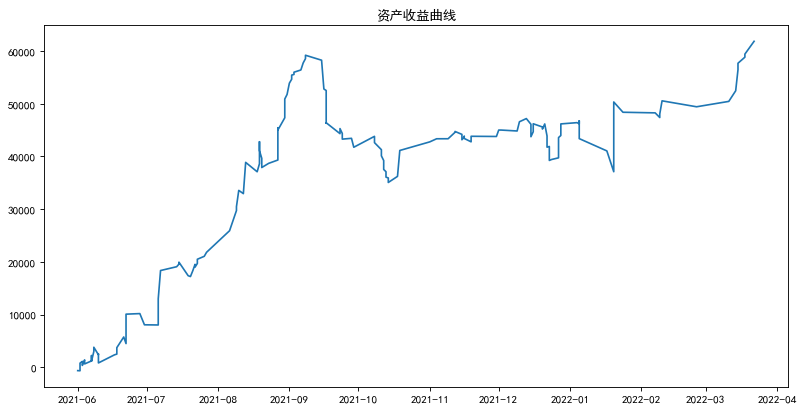

In [11]:
file = "交割单.xls"
e = Evaluator(name, file, preprocess_dcl)
e.run()


# 杨其旭

In [4]:
name = "杨其旭"

def preprocess_yqx(file):
    df = pd.read_excel(file, parse_dates=["成交日期"], header=1)
    print(df)

In [5]:
preprocess_yqx("/data/traders/杨其旭/2021.xls")

ValueError: Missing column provided to 'parse_dates': '成交日期'